In [1]:
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import graphviz as gv

### Politics!
This time I'm going to be looking at US presidential elections from 1976 to 2020. Specifically, it is broken down by state and by candidate, and has data about the number of votes each candidate received. It also has the total votes cast in each state. This immediately gives me some ideas.

Essentially, we currently have some idea of various political trends. I want to prove that they exist in the data. First, since candidates are relatively short-lived, I want to predict based on party rather than candidate. I also want to split my predictions based on state, since there will be very disparate trends. Finally, we'll be looking at trends through time.

First, I want to look at the percentage of votes each party received. This should elucidate trends in party preference by state by year. Second, purely whether each party won or lost. While heavily influenced by the percentage of votes, the binary nature of the data may give a slightly different perspective. Third, I want to look at the margin of victory. This is a little more complex, but I think it will be interesting to see how much each party won by. This should be an indirect measure of how divided the political landscape is (lower margins means closer races means more contention).

All three of those will require calculating their respective columns, so I'll do that first.

In [2]:
data = pd.read_csv('1976-2020-president.csv')
data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,2020,WYOMING,WY,56,83,68,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,5768,278503,20210113,NaN,LIBERTARIAN
4283,2020,WYOMING,WY,56,83,68,US PRESIDENT,"PIERCE, BROCK",INDEPENDENT,False,2208,278503,20210113,NaN,OTHER
4284,2020,WYOMING,WY,56,83,68,US PRESIDENT,NaN,NaN,True,1739,278503,20210113,NaN,OTHER
4285,2020,WYOMING,WY,56,83,68,US PRESIDENT,OVERVOTES,NaN,False,279,278503,20210113,NaN,OTHER


In [3]:
# a few ideas:
# perc_votes ~ party_simplified + state + year
# win ~ state + year + party_simplified
# margin ~ state + year + party_simplified

# need to compute a few columns
data['perc_votes'] = data['candidatevotes'] / data['totalvotes']
for row in data.iterrows():
    highest_other = max(data['candidatevotes'][(data.state == row[1]['state']) & (data.year == row[1]['year']) & (data.candidate != row[1]['candidate'])].values)
    if row[1]['candidatevotes'] > highest_other:
        data.loc[row[0], 'win'] = True
        data.loc[row[0], 'margin'] = row[1]['candidatevotes'] - highest_other
    else:
        data.loc[row[0], 'win'] = False
        data.loc[row[0], 'margin'] = None

data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,perc_votes,win,margin
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT,0.557273,True,155100.0
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN,0.426149,False,NaN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER,0.007776,False,NaN
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER,0.005638,False,NaN
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER,0.001652,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,2020,WYOMING,WY,56,83,68,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,5768,278503,20210113,NaN,LIBERTARIAN,0.020711,False,NaN
4283,2020,WYOMING,WY,56,83,68,US PRESIDENT,"PIERCE, BROCK",INDEPENDENT,False,2208,278503,20210113,NaN,OTHER,0.007928,False,NaN
4284,2020,WYOMING,WY,56,83,68,US PRESIDENT,NaN,NaN,True,1739,278503,20210113,NaN,OTHER,0.006244,False,NaN
4285,2020,WYOMING,WY,56,83,68,US PRESIDENT,OVERVOTES,NaN,False,279,278503,20210113,NaN,OTHER,0.001002,False,NaN


### Causal DAG
This is fairly straightforward. Everything feeds into margin, but almost everything feeds into percent of votes (except total votes), and whether they win is an analog for percent of votes. Essentially, I expect everything I mentioned above to be important.

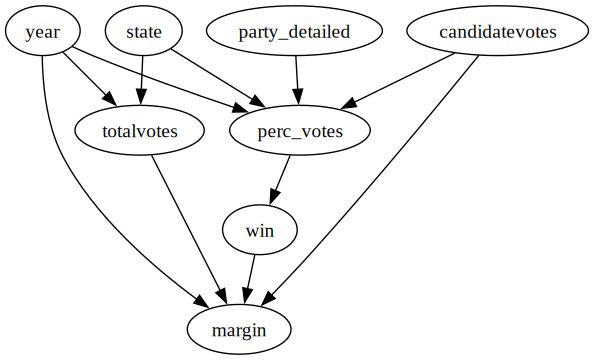

In [8]:
g = gv.Digraph(graph_attr={"size": "10,5!"})

for col in [c for c in data if "state_" not in c and c not in ["office", "version", "notes", "writein", "candidate", "party_simplified"]]: g.node(col)

g.edge("state", "totalvotes")
g.edge("year", "totalvotes")
g.edge("candidatevotes", "margin")
g.edge("totalvotes", "margin")
g.edge("win", "margin")
g.edge("year", "margin")
g.edge("year", "perc_votes")
g.edge("state", "perc_votes")
g.edge("party_detailed", "perc_votes")
g.edge("perc_votes", "win")
g.edge("candidatevotes", "perc_votes")

g

### Cleaning
As I found the hard way when trying to run the first model, `perc_votes` doesn't look great. Long story short, there are a lot of random parties and small candidates (or write-ins!) who got essentially 0 votes. I'll just let you look at the graph.

(array([2.488e+03, 2.550e+02, 8.600e+01, 4.400e+01, 2.400e+01, 1.800e+01,
        1.900e+01, 2.100e+01, 1.000e+01, 1.600e+01, 1.500e+01, 1.400e+01,
        6.000e+00, 5.000e+00, 7.000e+00, 5.000e+00, 4.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 6.000e+00,
        6.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 1.100e+01, 1.300e+01,
        8.000e+00, 8.000e+00, 1.000e+01, 8.000e+00, 1.500e+01, 1.800e+01,
        1.400e+01, 1.800e+01, 2.000e+01, 3.000e+01, 2.900e+01, 4.300e+01,
        2.300e+01, 4.100e+01, 4.200e+01, 3.300e+01, 3.900e+01, 4.500e+01,
        4.100e+01, 4.200e+01, 4.400e+01, 5.500e+01, 4.600e+01, 4.700e+01,
        3.500e+01, 3.700e+01, 3.200e+01, 3.100e+01, 3.200e+01, 3.000e+01,
        3.500e+01, 2.600e+01, 3.000e+01, 1.700e+01, 2.900e+01, 3.300e+01,
        1.600e+01, 1.900e+01, 8.000e+00, 4.000e+00, 1.100e+01, 6.000e+00,
        9.000e+00, 2.000e+00, 6.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 1.000e+0

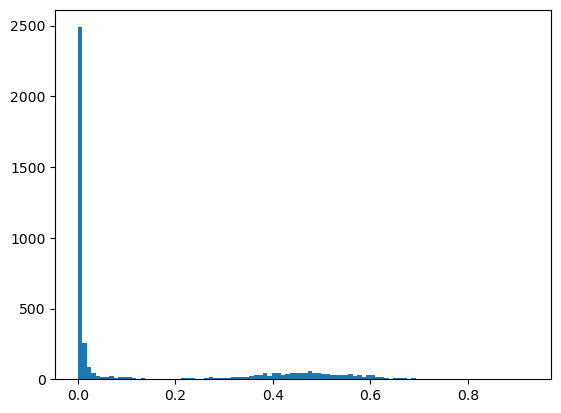

In [5]:
plt.hist(data['perc_votes'], bins=100)

#### First Clean
My first idea was to filter based on perc_votes. 0.03 is arbitrary. However, it still results in some bimodalism that I don't think is quite accurate. To confirm my suspicions, I looked at filtering by just the main two parties.

(array([42., 17., 18., 21., 16., 10., 17., 15., 13.,  5.,  5.,  8.,  5.,
         3.,  3.,  2.,  1.,  1.,  3.,  3.,  6.,  3.,  7.,  4.,  4.,  5.,
        11., 10., 10.,  8.,  9.,  8., 20., 14., 13., 16., 24., 26., 29.,
        42., 24., 38., 38., 33., 39., 45., 39., 40., 35., 50., 51., 47.,
        42., 37., 33., 27., 27., 31., 29., 37., 20., 29., 19., 27., 31.,
        17., 16.,  9.,  3., 11.,  6.,  8.,  2.,  6.,  2.,  3.,  2.,  2.,
         1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         3.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  2.]),
 array([0.03045302, 0.0393942 , 0.04833538, 0.05727656, 0.06621774,
        0.07515892, 0.0841001 , 0.09304128, 0.10198246, 0.11092364,
        0.11986482, 0.12880601, 0.13774719, 0.14668837, 0.15562955,
        0.16457073, 0.17351191, 0.18245309, 0.19139427, 0.20033545,
        0.20927663, 0.21821781, 0.22715899, 0.23610017, 0.24504136,
        0.25398254, 0.26292372, 0.2718649 , 0.28080608, 0.28974726,
        0.29868844, 0.3076

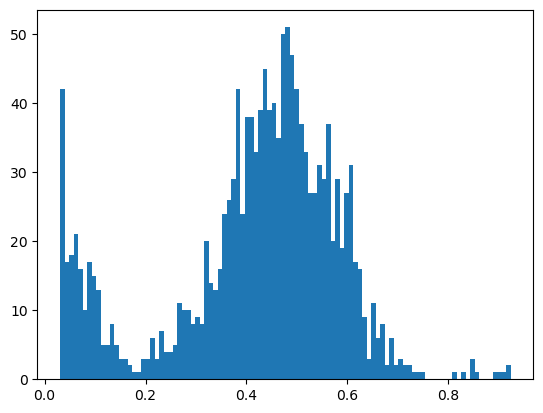

In [9]:
plt.hist(data[data['perc_votes'] > 0.03]['perc_votes'], bins=100)

(array([ 4.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  2.,  2.,  0.,  0.,
         0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         3.,  1.,  9., 10.,  7.,  8.,  9.,  8., 15., 18., 14., 18., 20.,
        30., 29., 43., 23., 41., 42., 33., 39., 45., 41., 42., 44., 55.,
        46., 47., 35., 37., 32., 31., 32., 30., 35., 26., 30., 17., 29.,
        33., 16., 19.,  8.,  4., 11.,  6.,  9.,  2.,  6.,  2.,  2.,  2.,
         3.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         1.,  3.,  0.,  0.,  0.,  1.,  1.,  1.,  2.]),
 array([2.93594851e-06, 9.24861756e-03, 1.84942992e-02, 2.77399808e-02,
        3.69856624e-02, 4.62313440e-02, 5.54770256e-02, 6.47227073e-02,
        7.39683889e-02, 8.32140705e-02, 9.24597521e-02, 1.01705434e-01,
        1.10951115e-01, 1.20196797e-01, 1.29442479e-01, 1.38688160e-01,
        1.47933842e-01, 1.57179523e-01, 1.66425205e-01, 1.75670887e-01,
        1.84916568e-01, 1.94162250e-01, 2.03407932e-01, 2.12653613e-01,
  

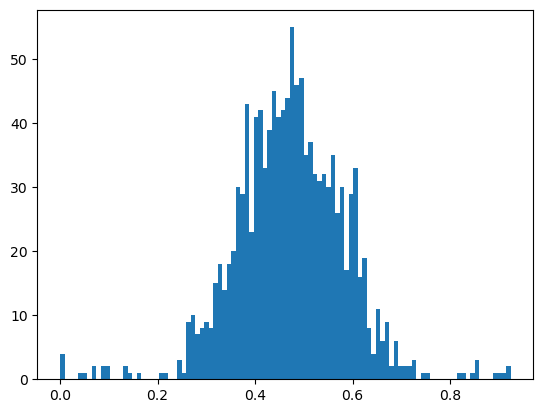

In [10]:
plt.hist(data[(data['party_simplified'] == "DEMOCRAT") | (data['party_simplified'] == "REPUBLICAN")]['perc_votes'], bins=100)

#### Cleaning Result
This looks much better. As expected, if you just look at the main two parties, we get a relatively normal distribution centered at 50%. We'll go with that.

In [4]:
# get rid of very small numbers and inf
clean = data[(data['party_simplified'] == "DEMOCRAT") | (data['party_simplified'] == "REPUBLICAN")]

predictors = clean[['year']]
predictors['party_simplified'] = pd.Categorical(clean['party_simplified']).codes
predictors['state'] = pd.Categorical(clean['state']).codes

/var/folders/54/8bqrgnxj1bz12y26lmhvlz2h0000gn/T/ipykernel_30847/285972767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors['party_simplified'] = pd.Categorical(clean['party_simplified']).codes
/var/folders/54/8bqrgnxj1bz12y26lmhvlz2h0000gn/T/ipykernel_30847/285972767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors['state'] = pd.Categorical(clean['state']).codes


### First Model
Since we're doing a BART, I want to make my support all real numbers rather than the purely positive percentage above. Originally I did this with a log transformation, but I then realized that I could simply transform the above normal distribution to center it at 0. This simplifies the model a little, and should be nice for BART. Since we're predicting a percentage, a Beta liklihood should work great. Also, in order to make it a little more interpretable, I want to work with the mu/sigma parameterization rather than the alpha/beta one.

#### Prior
The final consideration was the sigma prior. This took some... trial and error. Standard deviation is positive, so I went with a half normal. However, with the mu/sigma parameterization of the Beta, the standard deviation has to be low enough in comparison to the mean for all samples, or alpha or beta may be negative and the model will crash. I didn't bother leaving every single model I tried, because it was just tweaking the stdev prior's parameter. And also a lot of Googling about "bad initial energy". -_-

Once I got past figuring out the cleaning mentioned above and settled on the prior's parameters, things actually went quite smoothly. I'll show some graphs, then talk about the results.

In [16]:
# perc_votes ~ party_simplified + state + year

perc_votes_predictand = clean['perc_votes']
with pm.Model() as perc_votes_model:
    s = pm.HalfNormal('s',0.05) #random prior
    μ_ = pmb.BART("μ_", predictors, perc_votes_predictand - 0.5, m=50) # translate the data
    μ = pm.Deterministic("μ", μ_ + 0.5) # translate it back
    y = pm.Beta("y", mu=μ, sigma=s, observed=perc_votes_predictand) #predicting percentage, and we want to use mean/stdv
    idata_perc_votes = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.


Sampling: [y]


Output()

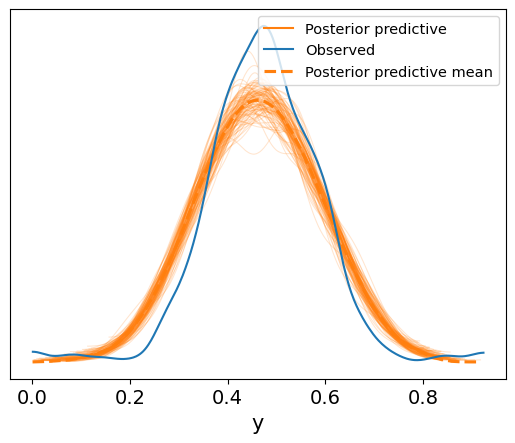

In [17]:
pm.sample_posterior_predictive(idata_perc_votes, perc_votes_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_perc_votes, num_pp_samples=100, colors=["C1", "C0", "C1"])

array([<Axes: xlabel='year'>, <Axes: xlabel='party_simplified'>,
       <Axes: xlabel='state'>], dtype=object)

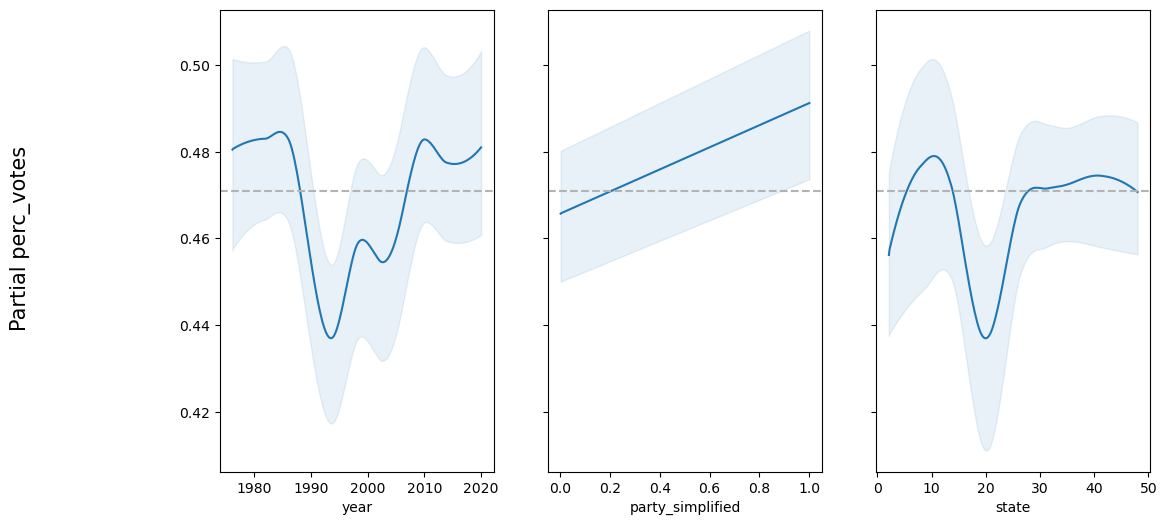

In [20]:
pmb.plot_pdp(μ_, predictors, perc_votes_predictand, grid=(1, 3), func=lambda n: n+0.5, figsize = (12, 6))

array([<Axes: xlabel='year'>, <Axes: xlabel='party_simplified'>,
       <Axes: xlabel='state'>], dtype=object)

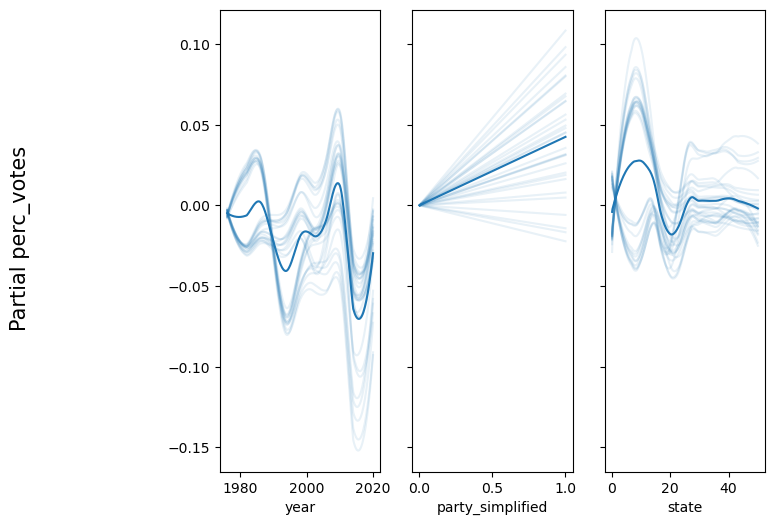

In [21]:
pmb.plot_ice(μ_, predictors, perc_votes_predictand, grid=(1, 5), func=lambda n: n+0.5, figsize = (12, 6))

<Axes: ylabel='R²'>

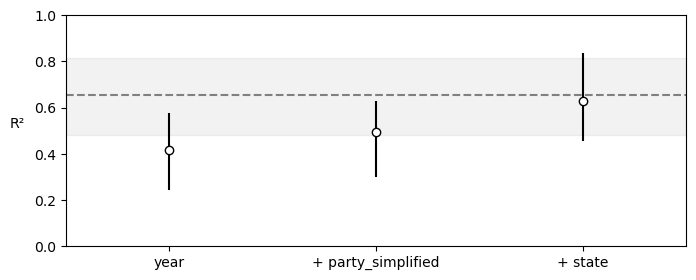

In [22]:
pmb.plot_variable_importance(pmb.compute_variable_importance(idata_perc_votes, μ_, predictors))

### Vote Percentage Results
Well the PPC looks pretty good, but frankly I don't much care about how good the model itself predicts the data. Also, what's basically a normal isn't very hard to predict.

The VI plot also confirms my choice in predictors. They all help by about the same amount, and we end up with a pretty good $R^2$ value. I'll keep going with those predictors for the next one, then.

Looking at the mess of the ICE plots, I'm not going to bother getting too far into the PDP; there are definitely interactions here. I'll start by looking at party (the middle graph). The average trend is actually upward, which means that in the past ~50 years, Republicans have typically gotten a higher percentage of the votes. I'm curious to see how that shows up when we're predicting the win/loss. However, there is a ton of variance here. My guess is that partly year, but mostly state is causing this. Based on which party is favored in a given state, the trend will either favor democrats (0) or republicans (1).

Moving onto the party graph, this is also quite interesting. For some of the states (first half of the graph), we see a reflection. That means these states strongly favor one party; the graph then reflects based on which party we're looking at. FOr the latter ~half, however, it is much more parallel (and flat). My best guess is that the ones that are flat (particularly around 0), are states that are more evenly split. These states have less interaction with the other variables (most notably, party).

Finally, there is little to no parallelism in the year graph. Once again, there is a lot of reflection; simultaneously positive and negative at any given year. This is similar to the party graph showing state preferences, but this elucidates a more national-level trend. The reflection in each year represents that there is often one party that is favored, nationally. Thus, the party interaction reflects the year plot. However, just like the states, the very end is still somewhat parallel. And takes a steep dive. I'll need to see how the margin model looks to get more info on this, this means that both major parties are getting a lower percentage of the votes, and party has less of an influence on the outcome. My postulation is that this represents disillusionment and division. It looks like in recent elections (2010 onwards), major parties took a huge hit in popularity, and party having less of an influence actually represents closer elections and therefore more division. Interestingly, though, that dip appears to be actively reversing.

### Second Model
This is very similar to the first model. This time, since we're predicting a binary outcome, I want to use a Bernoulli likelihood. BART will be predicting either a 0 or a 1, so we'll just give it a sigmoid to make it into a percentage. This time we don't need any arbitrary priors, so let's try it. See you after the plots.

In [26]:
# win ~ party_simplified + state + year

win_predictand = clean['win'].astype(int)
with pm.Model() as win_model:
    p_ = pmb.BART("p_", predictors, win_predictand, m=50)
    p = pm.Deterministic("p", pm.math.sigmoid(p_))
    y = pm.Bernoulli("y", p=p, observed=win_predictand)
    idata_win = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [p_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.


Sampling: [y]


Output()

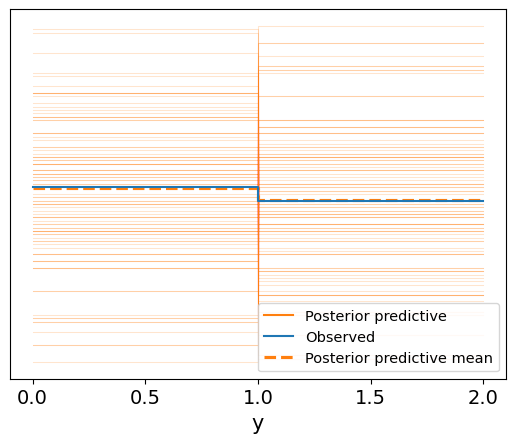

In [33]:
pm.sample_posterior_predictive(idata_win, win_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_win, num_pp_samples=100, colors=["C1", "C0", "C1"])

array([<Axes: xlabel='year'>, <Axes: xlabel='party_simplified'>,
       <Axes: xlabel='state'>], dtype=object)

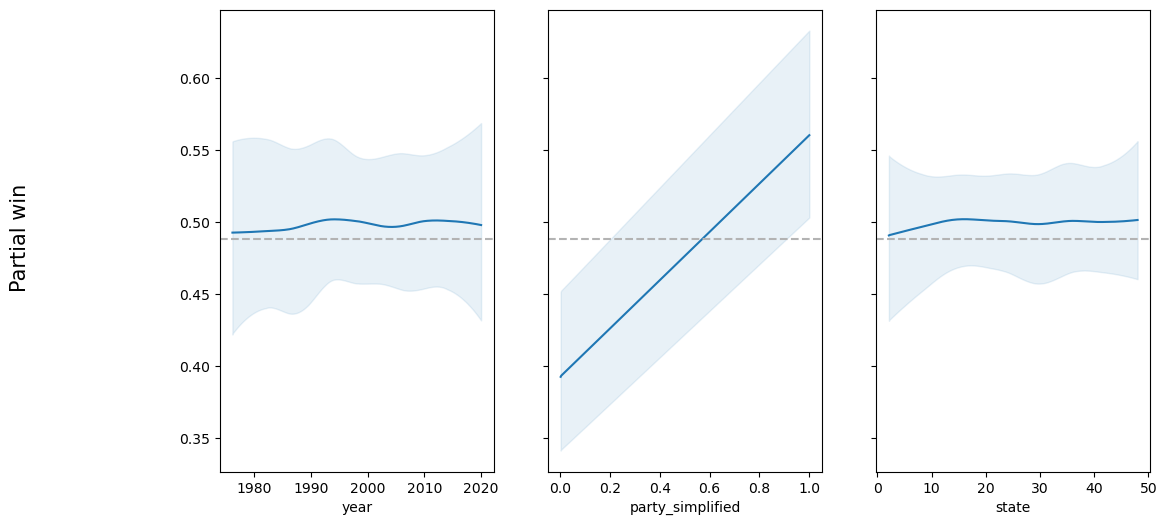

In [91]:
pmb.plot_pdp(p_, predictors, win_predictand, grid=(1, 3), func=lambda n: 1 / (1 + np.exp(-n)), figsize = (12, 6))

array([<Axes: xlabel='year'>, <Axes: xlabel='party_simplified'>,
       <Axes: xlabel='state'>], dtype=object)

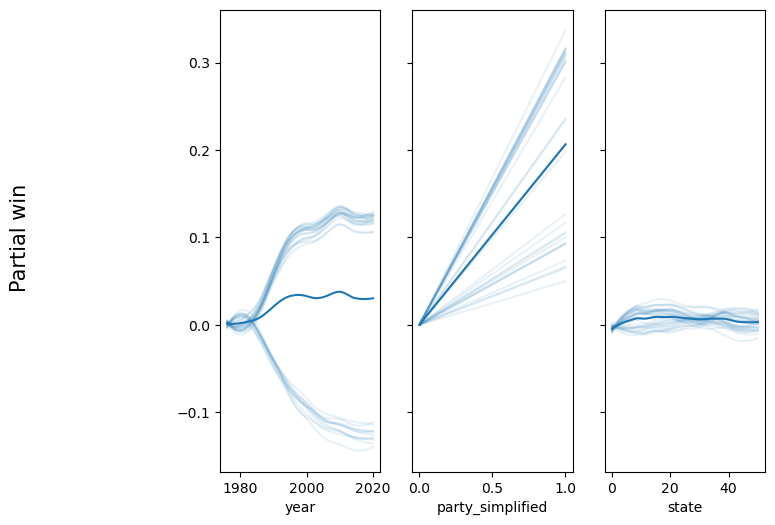

In [92]:
pmb.plot_ice(p_, predictors, win_predictand, grid=(1, 5), func=lambda n: 1 / (1 + np.exp(-n)), figsize = (12, 6))

(array([254.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 358.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

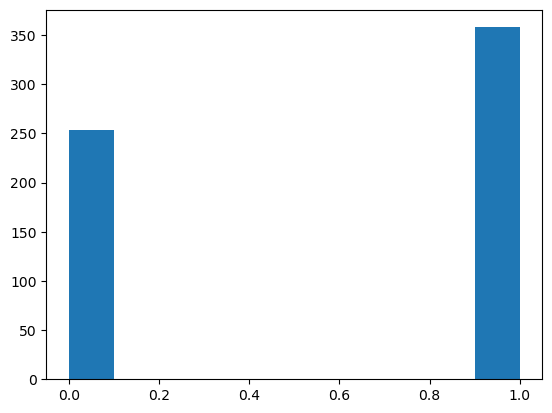

In [6]:
plt.hist(predictors['party_simplified'][clean['win']])

<Axes: ylabel='R²'>

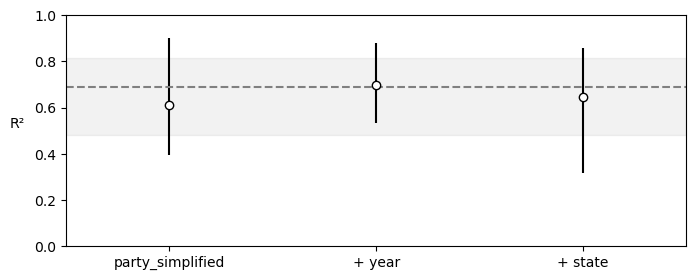

In [93]:
pmb.plot_variable_importance(pmb.compute_variable_importance(idata_win, p_, predictors))

### Win Results
As expected, this is an analog for the percentage of votes, but gives us a little clearer picture since it's binary data.

The PPC is... uninteligible, but again, that's not particularly important. Also again, the ICE plots show us that there is definitely interaction, so I won't really talk about the PDPs either. The first thing that stood out to me was the middle, party plot. Every single line trends upwards. To check my suspicions, I did a quick histogram plotting the parties of the winning candidates. Lo and behold, Republicans have a slight edge historically. This confirms what we would expect from history.

The state graph is quite different, however. Very parallel and very flat around zero. That actually is very interesting in the lack of a trend. This is actually visible in the VI plot too. Party on its own does incredibly well, year improves it just a little, and state actually worsens it.

This would appear to show that the almost sole determining factor of who wins is party, with year having a slight impact. With a larger time period, I predict year would have much more of an impact, but it makes sense that there would be slight shifts over 50 years.

Finally, looking at the year plot, there is actually quite a lot of parallelism; showcasing the small improvement year gives in the VI plot. However, this is quite interesting in that it starts out clustered around zero for about the 1980s. That means that for that time period, party didn't really affect who won (looking at the historical data, it was all Republicans - Reagan). However, it instantly diverges drastically, showing an almost exact reflection. This means that ever since, party has played a huge factor in who won every year. We'll see in the margin data, but I believe that this shows more polarization.

### Third Model
This one is a little more complex, but not too bad. We have to take out some nulls here, because there is only a win margin if the candidate, well, wins. We then log the data to make it support, and use a Gamma likelihood. Normal BART stuff. Should run nicely. Plot time!

In [35]:
# margin ~ party_simplified + state + year

margin_predictand = clean['margin']

margin_predictors = predictors[margin_predictand.notnull()]
margin_predictand = margin_predictand[margin_predictand.notnull()]

with pm.Model() as margin_model:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", margin_predictors, pm.math.log(margin_predictand)-12, m=50)
    μ = pm.Deterministic("μ", pm.math.exp(μ_+12))
    y = pm.Gamma("y", mu=μ, sigma=s, observed=margin_predictand)
    idata_margin = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


Sampling: [y]


Output()

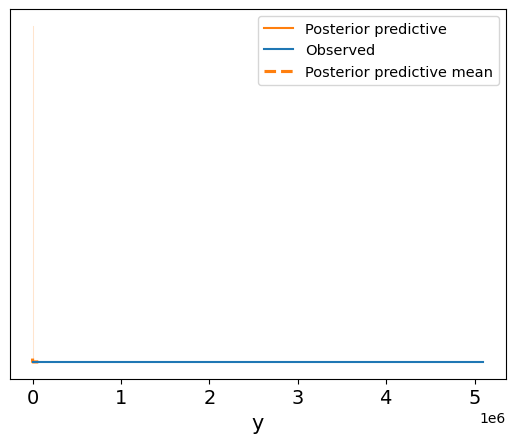

In [42]:
pm.sample_posterior_predictive(idata_margin, margin_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_margin, num_pp_samples=100, colors=["C1", "C0", "C1"])

array([<Axes: xlabel='year'>, <Axes: xlabel='party_simplified'>,
       <Axes: xlabel='state'>], dtype=object)

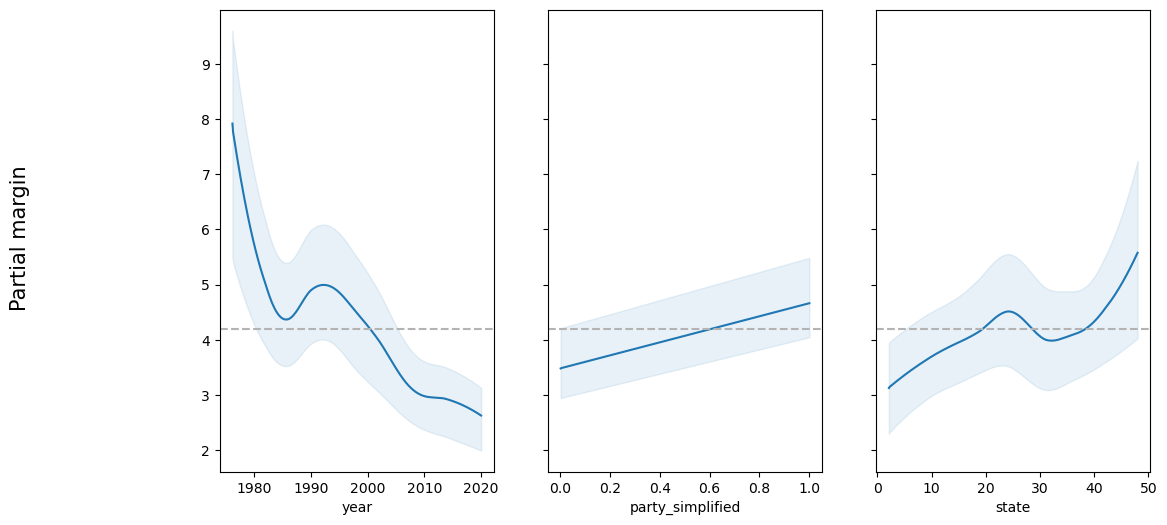

In [122]:
pmb.plot_pdp(μ_, margin_predictors, margin_predictand, grid=(1, 3), func=lambda n: np.exp(n+12), figsize = (12, 6))

array([<Axes: xlabel='year'>, <Axes: xlabel='party_simplified'>,
       <Axes: xlabel='state'>], dtype=object)

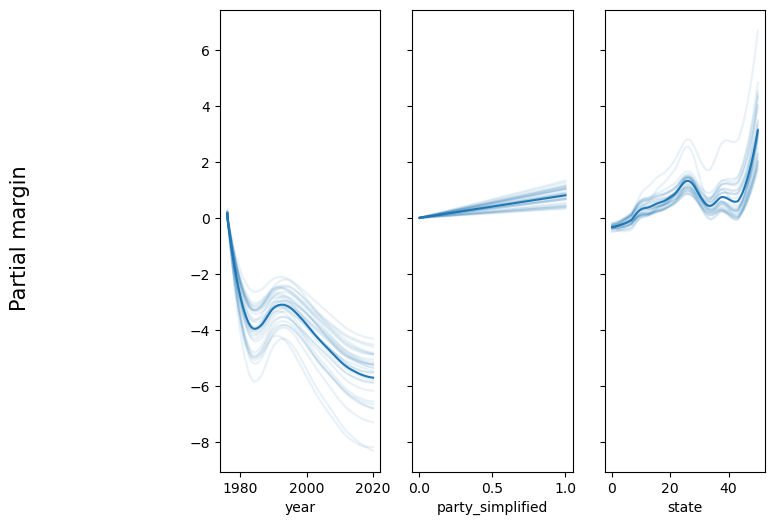

In [109]:
pmb.plot_ice(μ_, margin_predictors, margin_predictand, grid=(1, 5), func=lambda n: np.exp(n+12), figsize = (12, 6))

<Axes: ylabel='R²'>

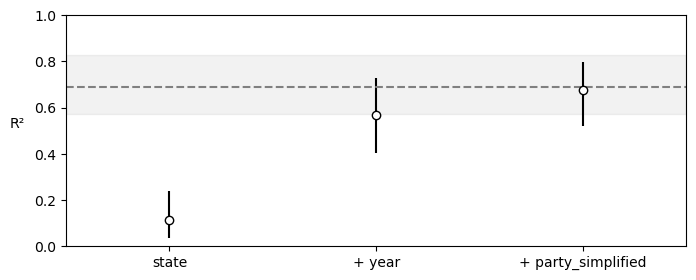

In [124]:
pmb.plot_variable_importance(pmb.compute_variable_importance(idata_margin, μ_, margin_predictors))

### Margin Results
Well somehow the PPC got even worse, but there is a lot of interesting info here. Firstly, the VI is telling us that party had relatively little effect compared to the others, but all of them were necessary. The major difference with this model, however, is that the ICE plots are actually unnecessary. There is very little interaction in these variables, meaning they each have a very clear (and distinct) effect. Let's take a look.

First, as expected, the party graph is very horizontal. Republicans seem to have a slightly greater margin of victory, but that's almost certainly just a holdover from the prior established trend of Republicans winning a lot from ~1980-2000. The state graph is also fairly tame, though certainly not flat. Essentially, some states have a stronger margin because they are more unified (prefer one party significantly). Interesting, the lack of interaction with year means that these are fairly set in stone for the past 50 years. There has been very, very little change in these trends. Again, if we had a bigger time period, I think there would be significantly more interaction as we would be able to witness the various party systems.

Finally, the year plot. This is pretty straightforward. As the years go on, the margins go down. There's a sharp descent immediately, likely coming off of the Reagan sweeps. Ever since the 1990s, however, the margins have been steadily declining. What makes that truly significant is that there is no population normalization in the data. This is raw win margins. Which means that even as total population goes up, the margins are still decreasing. This is a very clear indicator of increasing division. It does appear like it is concave up, however, so it is possible that this trend is reversing. We'll have to see in the coming years.

### Conclusion
This went exceedingly well. I was able to find clearly defined trends in the data, backed up by both colloquial and historical knowledge. I would love to see this run with a longer time period, but unfortunately the data largely doesn't exist (or would be a pain to find). Perhaps I'll look into it, though.

It would also be interesting to pull census data on population and party registered voters, and calculate the voter turnout by state, by year, and by party. Unfortunately I'm out of time on this project, but it would be interesting to show that colloquial trend in the data as well.

The bottom line of this analysis is that the US is becoming more divided. However, with the short time frame of the data, it's impossible to make a sweeping claim such as "the most divided in history", as we don't have history to compare to. It is also clear that party and national trends have not significantly changed in the past 50 years. But the consistently single best predictor of who will win? Party, dependent on state.